In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import xarray as xr
import xgcm
from matplotlib import pyplot as plt

import sectionate as sec
import regionate as reg

# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")

# Set figure font size
plt.rcParams.update({'font.size':12})

In [3]:
import matplotlib.pyplot as plt

def geoplot(ds, da, *args, **kwargs):
    pc = plt.pcolormesh(
        ds['geolon_c'],
        ds['geolat_c'],
        da,
        *args,
        **kwargs
    )
    return pc

## Applying `sectionate` and `regionmask` to look at heat flux into and out of the Caribbean

## 1. Load data

Here we load annual data on a $z^{*}$ (`zstr`) grid, but the same approach works for any vertical coordinate.

In [4]:
hf_x_368 = xr.open_mfdataset("/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.*.T_adx.nc")

In [5]:
hf_y_368 = xr.open_mfdataset("/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.*.T_ady.nc")

In [6]:
hf_x_319 = xr.open_mfdataset("/archive/Xinru.Li/MHWs/odiv319/ocean_annual_z.*.T_adx.nc")

In [7]:
hf_y_319 = xr.open_mfdataset("/archive/Xinru.Li/MHWs/odiv319/ocean_annual_z.*.T_ady.nc")
hf_y_319

<xarray.Dataset>
Dimensions:     (time: 65, z_l: 35, yq: 1081, xh: 1440, nv: 2, z_i: 36)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 1958-07-02 12:00:00 ... 2022-07-02 12:00:00
  * xh          (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yq          (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
  * z_i         (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l         (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Data variables:
    T_ady       (time, z_l, yq, xh) float32 dask.array<chunksize=(5, 35, 1081, 1440), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(5, 2), meta=np.ndarray>
Attributes:
    title:             om5_b02_minthick1em3_MLErestart
    associated_files:  areacello: 19580101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [8]:
# Here we load data on a (zstr) grid, but the same approach works for any vertical coordinate.
rootdir = '/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/'
prefix = 'ocean_annual_z'

og_368 = xr.open_mfdataset(f"{rootdir}{prefix}.static.nc")
ds_368 = xr.Dataset()  

ds_368 = xr.merge([ds_368, hf_x_368])
ds_368 = xr.merge([ds_368, hf_y_368])

ds_368 = ds_368.assign_coords({
    'xq': xr.DataArray(og_368['xq'].values, dims=('xq',)),
    'yq': xr.DataArray(og_368['yq'].values, dims=('yq',)),
    'geolon': xr.DataArray(og_368['geolon'].values, dims=('yh','xh')),
    'geolat': xr.DataArray(og_368['geolat'].values, dims=('yh','xh')),
    'geolon_u': xr.DataArray(og_368['geolon_u'].values, dims=('yh','xq')),
    'geolat_u': xr.DataArray(og_368['geolat_u'].values, dims=('yh','xq')),
    'geolon_v': xr.DataArray(og_368['geolon_v'].values, dims=('yq','xh')),
    'geolat_v': xr.DataArray(og_368['geolat_v'].values, dims=('yq','xh')),
    'geolon_c': xr.DataArray(og_368['geolon_c'].values, dims=('yq','xq')),
    'geolat_c': xr.DataArray(og_368['geolat_c'].values, dims=('yq','xq')),
    'dxCv': xr.DataArray(og_368['dxCv'].values, dims=('yq', 'xh',)),
    'dyCu': xr.DataArray(og_368['dyCu'].values, dims=('yh', 'xq',)),
    'deptho': xr.DataArray(og_368['deptho'].values, dims=('yh', 'xh',)),
}) # add velocity face widths to calculate distances along the section


coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'inner': 'z_l', 'outer': 'z_i'}
}
grid_368 = xgcm.Grid(ds_368, coords=coords, boundary={"X":"extend", "Y":"extend", "Z":"extend"}, autoparse_metadata=False)

# look for the heat content budget equation? 
rho0 = 1035. # kg/m^3 seawater density
Cp = 3992. # J/kg/K   specific heat capacity of seawater

In [9]:
# Here we load data on a (zstr) grid, but the same approach works for any vertical coordinate.
rootdir = '/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/'
prefix = 'ocean_annual_z'

og_319 = xr.open_mfdataset(f"{rootdir}{prefix}.static.nc")
ds_319 = xr.Dataset()  

ds_319 = xr.merge([ds_319, hf_x_319])
ds_319 = xr.merge([ds_319, hf_y_319])

ds_319 = ds_319.assign_coords({
    'xq': xr.DataArray(og_319['xq'].values, dims=('xq',)),
    'yq': xr.DataArray(og_319['yq'].values, dims=('yq',)),
    'geolon': xr.DataArray(og_319['geolon'].values, dims=('yh','xh')),
    'geolat': xr.DataArray(og_319['geolat'].values, dims=('yh','xh')),
    'geolon_u': xr.DataArray(og_319['geolon_u'].values, dims=('yh','xq')),
    'geolat_u': xr.DataArray(og_319['geolat_u'].values, dims=('yh','xq')),
    'geolon_v': xr.DataArray(og_319['geolon_v'].values, dims=('yq','xh')),
    'geolat_v': xr.DataArray(og_319['geolat_v'].values, dims=('yq','xh')),
    'geolon_c': xr.DataArray(og_319['geolon_c'].values, dims=('yq','xq')),
    'geolat_c': xr.DataArray(og_319['geolat_c'].values, dims=('yq','xq')),
    'dxCv': xr.DataArray(og_319['dxCv'].values, dims=('yq', 'xh',)),
    'dyCu': xr.DataArray(og_319['dyCu'].values, dims=('yh', 'xq',)),
    'deptho': xr.DataArray(og_319['deptho'].values, dims=('yh', 'xh',)),
}) # add velocity face widths to calculate distances along the section



coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'inner': 'z_l', 'outer': 'z_i'}
}
grid_319 = xgcm.Grid(ds_319, coords=coords, boundary={"X":"extend", "Y":"extend", "Z":"extend"}, autoparse_metadata=False)

# look for the heat content budget equation? 
rho0 = 1035. # kg/m^3 seawater density
Cp = 3992. # J/kg/K   specific heat capacity of seawater

In [10]:
ds_319

<xarray.Dataset>
Dimensions:     (time: 65, z_l: 35, yh: 1080, xq: 1441, nv: 2, z_i: 36,
                 yq: 1081, xh: 1440)
Coordinates: (12/19)
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 1958-07-02 12:00:00 ... 2022-07-02 12:00:00
  * yh          (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_i         (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l         (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * xh          (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
    ...          ...
    geolat_v    (yq, xh) float32 -79.78 -79.77 -79.77 -79.77 ... nan nan nan nan
    geolon_c    (yq, xq) float32 -299.6 -299.4 -299.1 -298.9 ... nan nan nan nan
    geolat_c    (yq, xq) float32 -79.77 -79.77 -79.77 -79.77 ... nan nan nan nan
    dxCv        (yq, xh) float32 4.904e+03 4.905e+03 4.905e+03 ... nan nan nan
    dyCu        (yh, xq) float32 7.044e+03 7.039e+03 7.034e+03 ... 0.1947 nan
    deptho      (yh, xh) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Data variables:
    T_adx       (time, z_l, yh, xq) float32 dask.array<chunksize=(5, 35, 1080, 1441), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(5, 2), meta=np.ndarray>
    T_ady       (time, z_l, yq, xh) float32 dask.array<chunksize=(5, 35, 1081, 1440), meta=np.ndarray>

In [11]:
ds_319.geolon[0,:].values

array([-299.71835 , -299.47037 , -299.2224  , ...,   59.537766,
         59.78573 ,   60.03369 ], dtype=float32)

In [12]:
ds_319.geolat[:,0].values

array([-79.80674 , -79.743546, -79.68049 , ...,  64.11358 ,  64.11359 ,
        64.11359 ], dtype=float32)

In [13]:
ds_319.T_adx  # calculate time integral heat flux at the lesser Antilles

<xarray.DataArray 'T_adx' (time: 65, z_l: 35, yh: 1080, xq: 1441)>
dask.array<concatenate, shape=(65, 35, 1080, 1441), dtype=float32, chunksize=(5, 35, 1080, 1441), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1958-07-02 12:00:00 ... 2022-07-02 12:00:00
  * yh        (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_l       (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * xq        (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.91 60.16 60.16
    geolon_u  (yh, xq) float32 -299.6 -299.3 -299.1 -298.9 ... 60.0 60.0 nan
    geolat_u  (yh, xq) float32 -79.81 -79.8 -79.8 -79.8 ... 64.17 64.06 nan
    dyCu      (yh, xq) float32 7.044e+03 7.039e+03 7.034e+03 ... 0.1947 nan
Attributes:
    units:          W
    long_name:      Advective (by residual mean) Zonal Flux of Heat
    cell_methods:   z_l:sum yh:sum xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

### 3.2. **Generalizing to any closed polygonal region, leveraging `sectionate`'s ability to find grid-conforming shortest paths**

In [14]:
# generate region mask for the Lesser Antilles
lons_319 = np.array([-70., -60., -60., -70.])  # -63, -58
lats_319 = np.array([11.5, 11.5, 18.5, 18.5])
region_319 = reg.GriddedRegion("Lesser Antilles", lons_319, lats_319, grid_319)

IndexError: index 0 is out of bounds for axis 0 with size 0

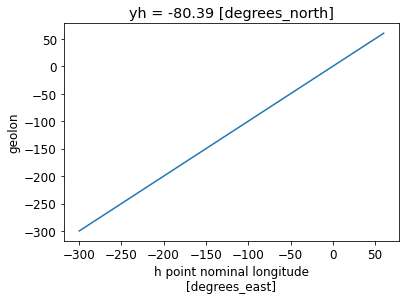

In [28]:
ds_319.geolon[0,:].plot()

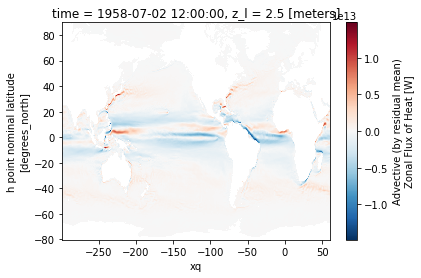

In [16]:
ds_319.T_adx[0,0,:,:].plot()

In [24]:
grid_319

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='extend'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='extend'):
  * inner    z_l
  * outer    z_i

In [49]:
import sectionate as sec

In [51]:
sec?

Type:        module
String form: <module 'sectionate' from '/nbhome/Xinru.Li/envs/py39/lib/python3.9/site-packages/sectionate/__init__.py'>
File:        /nbhome/Xinru.Li/envs/py39/lib/python3.9/site-packages/sectionate/__init__.py
Docstring:   <no docstring>

In [ ]:
def loop(x):
    return np.append(x, x[0])

In [ ]:
def get_region_boundary_grid_indices(lons, lats, grid):   

    if (lons[0], lats[0]) != (lons[-1], lats[-1]):
        lons, lats = loop(lons), loop(lats)
        
    i, j, lons_c, lats_c = sec.grid_section(  # this section didn't return right index of i, j, lons_c, lats_c : my guess is something to do with grid are different
        grid,
        lons,
        lats,
        topology="MOM-tripolar"
    )
    
    uvindices = sec.uvindices_from_qindices(grid, i, j)
    
    lons_uv, lats_uv = sec.uvcoords_from_uvindices(
        grid,
        uvindices
    )

    return (i, j, lons_c[:-1], lats_c[:-1], lons_uv, lats_uv)

In [17]:
    i, j, lons_c, lats_c = sec.grid_section(
        grid_319,
        lons_319,
        lats_319,
        topology="MOM-tripolar"
    )

In [18]:
i

array([1440])

In [19]:
j

array([0])

In [21]:
lons_c

array([nan])

In [22]:
lats_c

array([nan])

In [103]:
def grid_section(grid, lons, lats, topology="latlon"):
    """
    Compute composite section along model `grid` velocity faces that approximates geodesic paths
    between consecutive points defined by (lons, lats).

    Parameters
    ----------
    grid: xgcm.Grid
        Object describing the geometry of the ocean model grid, including metadata about variable names for
        the staggered C-grid dimensions and c oordinates.
    lons: list or np.ndarray
        Longitudes, in degrees, of consecutive vertices defining a piece-wise geodesic section.
    lats: list or np.ndarray
        Latitudes, in degrees (in range [-90, 90]), of consecutive vertices defining a piece-wise geodesic section.
    topology: str
        Default: "latlon". Currently only supports the following options: ["latlon", "cartesian", "MOM-tripolar"].
        
    Returns
    -------
    isect, jsect, lonsect, latsect: `np.ndarray` of types (int, int, float, float) 
        (isect, jsect) correspond to indices of vorticity points that define velocity faces.
        (lonsect, latsect) are the corresponding longitude and latitudes.
    """
    geocorners = get_geo_corners(grid)
    return create_section_composite(  # this function returned werid info !!!
        geocorners["X"],
        geocorners["Y"],
        lons,
        lats,
        check_symmetric(grid),
        boundary={ax:grid.axes[ax]._boundary for ax in grid.axes},
        topology=topology
    )

In [104]:
def get_geo_corners(grid):
    """
    Find longitude and latitude coordinates from grid dataset, assuming the coordinate
    names contain the sub-strings "lon" and "lat", respectively.

    Parameters
    ----------
    grid: xgcm.Grid
        Contains information about ocean model grid discretization, e.g. coordinates and metrics.
        
    Returns
    -------
    dict
        Dictionary containing names of longitude and latitude coordinates.
    """
    dims = {}
    for axis in ["X", "Y"]:
        if "outer" in grid.axes[axis].coords:
            dims[axis] = grid.axes[axis].coords["outer"]
        elif "right" in grid.axes[axis].coords:
            dims[axis] = grid.axes[axis].coords["right"]
        else:
            raise ValueError("Only 'symmetric' and 'non-symmetric' grids\
            are currently supported. They require C-grid topology, i.e. with\
            vorticity coordinates at 'outer' and 'right' positions, respectively.")

    coords = grid._ds.coords
    return {
        axis: [
            coords[c] for c in coords
            if (
                (geoc in c) and
                (dims["X"] in coords[c].dims) and
                (dims["Y"] in coords[c].dims)
            )
        ][0]
        for axis, geoc in zip(["X", "Y"], ["lon", "lat"])
    }

In [62]:
def check_symmetric(grid):
    """
    Check whether the horizontal ocean model grid is symmetric or not, according to MOM6 conventions.
    Symmetric C-grids have tracers on (M,N) 'center' positions and vorticity on (M+1, N+1) 'outer' positions.
    Non-symmetric C-grids instead have vorticity on (M,N) 'right' positions.

    Parameters
    ----------
    grid: xgcm.Grid
        Contains information about ocean model grid discretization, e.g. coordinates and metrics.
        
    Returns
    -------
    symmetric : bool
        True if symmetric; False if non-symmetric.
        
    """
    pos_dict = {
        p : ((p in grid.axes["X"].coords) and (p in grid.axes["Y"].coords))
        for p in ["outer", "right"]
    }
    if pos_dict["outer"]:
        return True
    elif pos_dict["right"]:
        return False
    else:
        raise ValueError("Horizontal grid axes ('X', 'Y') must be either both symmetric or both non-symmetric (by MOM6 conventions).")
        
check_symmetric(grid_319)

In [61]:
def create_section_composite(
    gridlon,
    gridlat,
    lons,
    lats,
    symmetric,
    boundary={"X":"periodic", "Y":"extend"},
    topology="latlon"
    ):
    """
    Compute composite section along velocity faces, as defined by coordinates of vorticity points (gridlon, gridlat),
    that most closely approximates geodesic paths between consecutive points defined by (lons, lats).

    PARAMETERS:
    -----------

    gridlon: np.ndarray
        2d array of longitude (with dimensions ("Y", "X")), in degrees
    gridlat: np.ndarray
        2d array of latitude (with dimensions ("Y", "X")), in degrees
    lons: list of float
        longitude of section starting, intermediate and end points, in degrees
    lats: list of float
        latitude of section starting, intermediate and end points, in degrees
    symmetric: bool
        True if symmetric (vorticity on "outer" positions); False if non-symmetric (assuming "right" positions).
    boundary: dictionary mapping grid axis to boundary condition
        Default: {"X":"periodic", "Y":"extend"}. Set to {"X":"extend", "Y":"extend"} if using a non-periodic regional domain.
    topology: str
        Default: "latlon". Currently only supports the following options: ["latlon", "cartesian", "MOM-tripolar"].

    RETURNS:
    -------

    isect, jsect, lonsect, latsect: `np.ndarray` of types (int, int, float, float) 
        (isect, jsect) correspond to indices of vorticity points that define velocity faces.
        (lonsect, latsect) are the corresponding longitude and latitudes.
    """

    isect = np.array([], dtype=np.int64)
    jsect = np.array([], dtype=np.int64)
    lonsect = np.array([], dtype=np.float64)
    latsect = np.array([], dtype=np.float64)

    if len(lons) != len(lats):
        raise ValueError("lons and lats should have the same length")

    for k in range(len(lons) - 1):
        iseg, jseg, lonseg, latseg = create_section(   # further this function cannot reture consistent info !!!
            gridlon,
            gridlat,
            lons[k],
            lats[k],
            lons[k + 1],
            lats[k + 1],
            symmetric,
            boundary=boundary,
            topology=topology
        )

        isect = np.concatenate([isect, iseg[:-1]], axis=0)
        jsect = np.concatenate([jsect, jseg[:-1]], axis=0)
        lonsect = np.concatenate([lonsect, lonseg[:-1]], axis=0)
        latsect = np.concatenate([latsect, latseg[:-1]], axis=0)
        
    isect = np.concatenate([isect, [iseg[-1]]], axis=0)
    jsect = np.concatenate([jsect, [jseg[-1]]], axis=0)
    lonsect = np.concatenate([lonsect, [lonseg[-1]]], axis=0)
    latsect = np.concatenate([latsect, [latseg[-1]]], axis=0)

    return isect.astype(np.int64), jsect.astype(np.int64), lonsect, latsect

In [106]:
def create_section(gridlon, gridlat, lonstart, latstart, lonend, latend, symmetric, boundary={"X":"periodic", "Y":"extend"}, topology="latlon"):
    """
    Compute a section segment along velocity faces, as defined by coordinates of vorticity points (gridlon, gridlat),
    that most closely approximates the geodesic path between points (lonstart, latstart) and (lonend, latend).

    PARAMETERS:
    -----------

    gridlon: np.ndarray
        2d array of longitude (with dimensions ("Y", "X")), in degrees
    gridlat: np.ndarray
        2d array of latitude (with dimensions ("Y", "X")), in degrees
    lonstart: float
        longitude of starting point, in degrees
    lonend: float
        longitude of end point, in degrees
    latstart: float
        latitude of starting point, in degrees
    latend: float
        latitude of end point, in degrees
    symmetric: bool
        True if symmetric (vorticity on "outer" positions); False if non-symmetric (assuming "right" positions).
    boundary: dictionary mapping grid axis to boundary condition
        Default: {"X":"periodic", "Y":"extend"}. Set to {"X":"extend", "Y":"extend"} if using a non-periodic regional domain.
    topology: str
        Default: "latlon". Currently only supports the following options: ["latlon", "cartesian", "MOM-tripolar"].

    RETURNS:
    -------

    isect, jsect, lonsect, latsect: `np.ndarray` of types (int, int, float, float) 
        (isect, jsect) correspond to indices of vorticity points that define velocity faces.
        (lonsect, latsect) are the corresponding longitude and latitudes.
    """

    if symmetric and boundary["X"] == "periodic":
        gridlon=gridlon[:,:-1]
        gridlat=gridlat[:,:-1]

    iseg, jseg, lonseg, latseg = infer_grid_path_from_geo(
        lonstart,
        latstart,
        lonend,
        latend,
        gridlon,
        gridlat,
        boundary=boundary,
        topology=topology
    )
    return (
        iseg,
        jseg,
        lonseg,
        latseg
    )

In [111]:
def find_closest_grid_point(lon, lat, gridlon, gridlat):
    """
    Find integer indices of closest grid point in grid of coordinates
    (gridlon, gridlat), for a given point (lon, at).

    PARAMETERS:
    -----------
        lon (float): longitude of point to find, in degrees
        lat (float): latitude of point to find, in degrees
        gridlon (numpy.ndarray): grid longitudes, in degrees
        gridlat (numpy.ndarray): grid latitudes, in degrees

    RETURNS:
    --------

    iclose, jclose: integer
        grid indices for geographical point of interest
    """

    if isinstance(gridlon, xr.core.dataarray.DataArray):
        gridlon = gridlon.values
    if isinstance(gridlat, xr.core.dataarray.DataArray):
        gridlat = gridlat.values
    dist = distance_on_unit_sphere(lon, lat, gridlon, gridlat)
    jclose, iclose = np.unravel_index(dist.argmin(), gridlon.shape)
    return iclose, jclose

In [113]:
def infer_grid_path_from_geo(lonstart, latstart, lonend, latend, gridlon, gridlat, boundary={"X":"periodic", "Y":"extend"}, topology="latlon"):
    """
    Find the grid indices (and coordinates) of vorticity points that most closely approximates
    the geodesic path between points (lonstart, latstart) and (lonend, latend).

    PARAMETERS:
    -----------

    lonstart: float
        longitude of section starting point, in degrees
    latstart: float
        latitude of section starting point, in degrees
    lonend: float
        longitude of section end point, in degrees
    latend: float
        latitude of section end point, in degrees
    gridlon: np.ndarray
        2d array of longitude, in degrees
    gridlat: np.ndarray
        2d array of latitude, in degrees
    boundary: dictionary mapping grid axis to boundary condition
        Default: {"X":"periodic", "Y":"extend"}. Set to {"X":"extend", "Y":"extend"} if using a non-periodic regional domain.
    topology: str
        Default: "latlon". Currently only supports the following options: ["latlon", "cartesian", "MOM-tripolar"].

    RETURNS:
    -------

    isect, jsect, lonsect, latsect: `np.ndarray` of types (int, int, float, float) 
        (isect, jsect) correspond to indices of vorticity points that define velocity faces.
        (lonsect, latsect) are the corresponding longitude and latitudes.
    """

    istart, jstart = find_closest_grid_point(
        lonstart,
        latstart,
        gridlon,
        gridlat
    )
    iend, jend = find_closest_grid_point(
        lonend,
        latend,
        gridlon,
        gridlat
    )
    iseg, jseg, lonseg, latseg = infer_grid_path(
        istart,
        jstart,
        iend,
        jend,
        gridlon,
        gridlat,
        boundary=boundary,
        topology=topology
    )

    return iseg, jseg, lonseg, latseg


In [115]:
def distance_on_unit_sphere(lon1, lat1, lon2, lat2, R=6.371e6, method="vincenty"):
    """
    Calculate geodesic arc distance between points (lon1, lat1) and (lon2, lat2).

    PARAMETERS:
    -----------
        lon1 : float
            Start longitude(s), in degrees
        lat1 : float
            Start latitude(s), in degrees
        lon2 : float
            End longitude(s), in degrees
        lat2 : float
            End latitude(s), in degrees
        R : float
            Radius of sphere. Default: 6.371e6 (realistic Earth value). Set to 1 for
            arc distance in radius.
        method : str
            Name of method. Supported methods: ["vincenty", "haversine", "law of cosines"].
            Default: "vincenty", which is the most robust. Note, however, that it still can result in
            vanishingly small (but crucially non-zero) errors; such as that the distance between (0., 0.)
            and (360., 0.) is 1.e-16 meters when it should be identically zero.

    RETURNS:
    --------

    dist : float
        Geodesic distance between points (lon1, lat1) and (lon2, lat2).
    """
    
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    dphi = np.abs(phi2-phi1)
    
    lam1 = np.deg2rad(lon1)
    lam2 = np.deg2rad(lon2)
    dlam = np.abs(lam2-lam1)
    
    if method=="vincenty":
        numerator = np.sqrt(
            (np.cos(phi2)*np.sin(dlam))**2 +
            (np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(dlam))**2
        )
        denominator = np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(dlam)
        arc = np.arctan2(numerator, denominator)
        
    elif method=="haversine":
        arc = 2*np.arcsin(np.sqrt(
            np.sin(dphi/2.)**2 + (1. - np.sin(dphi/2.)**2 - np.sin((phi1+phi2)/2.)**2)*np.sin(dlam/2.)**2
        ))
    
        
    elif method=="law of cosines":
        arc = np.arccos(
            np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(dlam)
        )

    return R * arc

In [117]:
def infer_grid_path(i1, j1, i2, j2, gridlon, gridlat, boundary={"X":"periodic", "Y":"extend"}, topology="latlon"):
    """
    Find the grid indices (and coordinates) of vorticity points that most closely approximate
    the geodesic path between points (gridlon[j1,i1], gridlat[j1,i1]) and
    (gridlon[j2,i2], gridlat[j2,i2]).

    PARAMETERS:
    -----------

    i1: integer
        i-coord of point1
    j1: integer
        j-coord of point1
    i2: integer
        i-coord of point2
    j2: integer
        j-coord of point2
    gridlon: np.ndarray
        2d array of longitude, in degrees
    gridlat: np.ndarray
        2d array of latitude, in degrees
    boundary: dictionary mapping grid axis to boundary condition
        Default: {"X":"periodic", "Y":"extend"}. Set to {"X":"extend", "Y":"extend"} if using a non-periodic regional domain.
    topology: str
        Default: "latlon". Currently only supports the following options: ["latlon", "cartesian", "MOM-tripolar"].

    RETURNS:
    -------

    iseg, jseg: list of int
        list of (i,j) pairs bounded by (i1, j1) and (i2, j2)
    lonseg, latseg: list of float
        corresponding longitude and latitude for iseg, jseg
    """
    ny, nx = gridlon.shape
    
    if isinstance(gridlon, xr.core.dataarray.DataArray):
        gridlon = gridlon.values
    if isinstance(gridlat, xr.core.dataarray.DataArray):
        gridlat = gridlat.values

    # target coordinates
    lon1, lat1 = gridlon[j1, i1], gridlat[j1, i1]
    lon2, lat2 = gridlon[j2, i2], gridlat[j2, i2]
    
    # init loop index to starting position
    i = i1
    j = j1

    iseg = [i]  # add first point to list of points
    jseg = [j]  # add first point to list of points

    # iterate through the grid path steps until we reach end of section
    ct = 0 # grid path step counter

    # Grid-agnostic algorithm:
    # First, find all four neighbors (subject to grid topology)
    # Second, throw away any that are further from the destination than the current point
    # Third, go to the valid neighbor that has the smallest angle from the arc path between the
    # start and end points (the shortest geodesic path)
    j_prev, i_prev = j,i
    while (i%nx != i2) or (j != j2):
                
        # safety precaution: exit after taking enough steps to have crossed the entire model grid
        if ct > (nx+ny+1):
            raise RuntimeError(f"Should have reached the endpoint by now.")

        d_current = distance_on_unit_sphere(
                gridlon[j,i],
                gridlat[j,i],
                lon2,
                lat2
            )
        
        if d_current < 1.e-12:
            break
        
        if boundary["X"] == "periodic":
            right = (j, (i+1)%nx)
            left = (j, (i-1)%nx)
        else:
            right = (j, np.clip(i+1, 0, nx-1))
            left = (j, np.clip(i-1, 0, nx-1))
        down = (np.clip(j-1, 0, ny-1), i)
        
        if topology=="MOM-tripolar":
            if j!=ny-1:
                up = (j+1, i%nx)
            else:
                up = (j-1, (nx-1) - (i%nx))
                
        elif topology=="cartesian" or topology=="latlon":
                up = (np.clip(j+1, 0, ny-1), i)
        else:
            raise ValueError("Only 'cartesian', 'latlon', and 'MOM-tripolar' grid topologies are currently supported.")
        
        neighbors = [right, left, down, up]

        j_next, i_next = None, None
        smallest_angle = np.inf
        d_list = []
        for (_j, _i) in neighbors:
            d = distance_on_unit_sphere(
                gridlon[_j,_i],
                gridlat[_j,_i],
                lon2,
                lat2
            )
            d_list.append(d/d_current)
            if d < d_current:
                if d==0.: # We're done!
                    j_next, i_next = _j, _i
                    smallest_angle = 0.
                    break
                # Instead of simply moving to the point that gets us closest to the target,
                # a more robust approach is to pick, among the points that do get us closer,
                # the one that most closely follows the great circle between the start and
                # end points of the section. We average the angles relative to both end
                # points so that the shortest path is unique and insensitive to which direction
                # the section is traveled.
                else:
                    angle1 = spherical_angle(
                        lon2,
                        lat2,
                        lon1,
                        lat1,
                        gridlon[_j,_i],
                        gridlat[_j,_i],
                    )
                    angle2 = spherical_angle(
                        lon1,
                        lat1,
                        lon2,
                        lat2,
                        gridlon[_j,_i],
                        gridlat[_j,_i],
                    )
                    angle = (angle1+angle2)/2.
                    if angle < smallest_angle:
                        j_next, i_next = _j, _i
                        smallest_angle = angle
        
        # There can be some strange edge cases in which none of the neighboring points
        # actually get us closer to the target (e.g. when closing folds in the grid).
        # In these cases, simply pick the adjacent point that gets us closest, as long as
        # it was not our previous point (to avoid endless loops). This algorithm should be
        # guaranteed to always get us to the target point.
        if (smallest_angle == np.inf) or (j_next, i_next) == (j_prev, i_prev):
            if (j_prev, i_prev) in neighbors:
                idx = neighbors.index((j_prev, i_prev))
                del neighbors[idx]
                del d_list[idx]
            
            (j_next, i_next) = neighbors[np.argmin(d_list)]

        j_prev, i_prev = j,i
        
        j = j_next
        i = i_next

        iseg.append(i)
        jseg.append(j)
        
        ct+=1

    # create lat/lon vectors from i,j pairs
    lonseg = []
    latseg = []
    for jj, ji in zip(jseg, iseg):
        lonseg.append(gridlon[jj, ji])
        latseg.append(gridlat[jj, ji])
    return np.array(iseg), np.array(jseg), np.array(lonseg), np.array(latseg)

In [15]:
    for k in range(len(lons) - 1):
        iseg, jseg, lonseg, latseg = create_section(
            gridlon,
            gridlat,
            lons[k],
            lats[k],
            lons[k + 1],
            lats[k + 1],
            symmetric,
            boundary=boundary,
            topology=topology
        )

NameError: name 'lons' is not defined

In [120]:
iseg

array([1440])

In [ ]:
jseg, lonseg, latseg

In [ ]:
#create section

In [127]:
    if symmetric and boundary["X"] == "periodic":   # false also in the example
        gridlon=gridlon[:,:-1]
        gridlat=gridlat[:,:-1]

In [131]:

    iseg, jseg, lonseg, latseg = infer_grid_path_from_geo(
        lonstart,
        latstart,
        lonend,
        latend,
        gridlon,
        gridlat,
        boundary=boundary,
        topology=topology
    )

In [130]:
iseg

array([1440])

In [134]:
k

3

In [ ]:
# infer...

In [166]:
    istart, jstart = find_closest_grid_point(
        lonstart,
        latstart,
        gridlon,
        gridlat
    )
    iend, jend = find_closest_grid_point(
        lonend,
        latend,
        gridlon,
        gridlat
    )
    iseg, jseg, lonseg, latseg = infer_grid_path(
        istart,
        jstart,
        iend,
        jend,
        gridlon,
        gridlat,
        boundary=boundary,
        topology=topology
    )

In [167]:
iseg, jseg, lonseg, latseg

(array([1440]),
 array([0]),
 array([nan], dtype=float32),
 array([nan], dtype=float32))

In [ ]:
# ?? longstart ...

In [168]:
istart, jstart

(1440, 0)

In [169]:
iend, jend 

(1440, 0)

In [170]:
lonend, latend

(50.0, 11.5)

In [171]:
lonstart, latstart

(43.0, 11.5)

In [ ]:
# ?? istart ...

In [ ]:
#find_closest_grid_point(

In [158]:
    if isinstance(gridlon, xr.core.dataarray.DataArray):
        gridlon = gridlon.values
    if isinstance(gridlat, xr.core.dataarray.DataArray):
        gridlat = gridlat.values
    dist = distance_on_unit_sphere(lonstart, latstart, gridlon, gridlat)
    jclose, iclose = np.unravel_index(dist.argmin(), gridlon.shape)

In [164]:
np.unravel_index([22, 41, 37], (7,6))  # ?? what does this function do

(array([3, 6, 6]), array([4, 5, 1]))

In [162]:
dist.argmin()

1440

In [163]:
gridlon.shape

(1081, 1441)

In [165]:
np.unravel_index(d1440, gridlon.shape)

(0, 1440)

In [154]:
jclose, iclose

(0, 1440)

In [159]:
dist.shape

(1081, 1441)

In [156]:
dist.shape

(1081, 1441)

In [140]:
np.unravel_index(dist.argmin(), gridlon.shape)

(0, 1440)

In [ ]:
# ?? infer_grid_path()

In [65]:
boundary={ax:grid_319.axes[ax]._boundary for ax in grid_319.axes}
boundary

{'X': 'extend', 'Y': 'extend', 'Z': 'extend'}

In [56]:
geocorners = get_geo_corners(grid_319)

In [57]:
geocorners

{'X': <xarray.DataArray 'geolon_c' (yq: 1081, xq: 1441)>
 array([[-299.60022 , -299.35217 , -299.10413 , ...,   59.90369 ,
           60.151733,         nan],
        [-299.61154 , -299.36334 , -299.11514 , ...,   59.892075,
           60.140266,         nan],
        [-299.6223  , -299.374   , -299.12564 , ...,   59.88101 ,
           60.129337,         nan],
        ...,
        [-299.99796 , -299.9959  , -299.99387 , ...,   59.99795 ,
           60.      ,         nan],
        [-300.      , -300.      , -300.      , ..., -300.      ,
         -300.      ,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]], dtype=float32)
 Coordinates:
   * xq        (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.91 60.16 60.16
   * yq        (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0 90.0
     geolon_c  (yq, xq) float32 -299.6 -299.4 -299.1 -298.9 ... nan nan nan nan
     geolat_c  (yq, xq) float32 -79.77 -79.77 -7

In [68]:
geocorners["Y"]

<xarray.DataArray 'geolat_c' (yq: 1081, xq: 1441)>
array([[-79.7744  , -79.77296 , -79.77153 , ..., -79.777336, -79.775856,
               nan],
       [-79.711296, -79.7099  , -79.70852 , ..., -79.714134, -79.71271 ,
               nan],
       [-79.64833 , -79.64698 , -79.64565 , ..., -79.65107 , -79.6497  ,
               nan],
       ...,
       [ 64.168106,  64.276825,  64.38512 , ...,  64.168106,  64.05896 ,
               nan],
       [ 64.168106,  64.27683 ,  64.38513 , ...,  64.168106,  64.05896 ,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * xq        (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.91 60.16 60.16
  * yq        (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0 90.0
    geolon_c  (yq, xq) float32 -299.6 -299.4 -299.1 -298.9 ... nan nan nan nan
    geolat_c  (yq, xq) float32 -79.77 -79.77 -79.77 -79.77 ... nan nan nan nan

In [ ]:
infer_grid_path_from_geo(lonstart, latstart, lonend, latend, gridlon, gridlat, boundary={"X":"periodic", "Y":"extend"}, topology="latlon")

In [73]:
gridlon = geocorners["X"]
gridlat = geocorners["Y"]
symmetric=True

In [160]:
    for k in range(len(lons_319) - 1):
        iseg, jseg, lonseg, latseg = create_section(
            gridlon,
            gridlat,
            lons_319[k],
            lats_319[k],
            lons_319[k + 1],
            lats_319[k + 1],
            symmetric,
            boundary=boundary,
            topology=topology
        )

In [33]:
x = get_region_boundary_grid_indices(lons_319, lats_319, grid_319)

In [36]:
x[1]

array([0])

### heat flux at each depth

In [32]:
heat_flux_x = hf_y_319['T_ady']
heat_flux_x  = heat_flux_x.where(heat_flux_x!=0.) 

In [33]:
og.depth_ocean.where(~region.mask)

<xarray.DataArray 'depth_ocean' (yh: 105, xh: 97)>
dask.array<where, shape=(105, 97), dtype=float32, chunksize=(105, 97), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 6.125 6.375 6.625 6.875 ... 29.38 29.62 29.88 30.12
  * yh       (yh) float64 53.01 53.16 53.31 53.46 ... 65.31 65.39 65.48 65.56
    time     object 1900-01-16 12:00:00
    geolon   (yh, xh) float32 6.125 6.375 6.625 6.875 ... 29.71 29.96 30.21
    geolat   (yh, xh) float32 53.01 53.01 53.01 53.01 ... 65.09 65.08 65.07
    deptho   (yh, xh) float32 9.5 nan nan nan 9.5 nan ... nan nan nan nan nan
Attributes:
    long_name:      Depth of the ocean at tracer points
    units:          m
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: area_t
    standard_name:  sea_floor_depth_below_geoid

In [35]:
heat_flux_x.where(region.mask).shape

(65, 35, 1081, 0, 105)

TypeError: Dimensions of C (65, 35, 1081, 0, 105) should be one smaller than X(97) and Y(105) while using shading='flat' see help(pcolormesh)

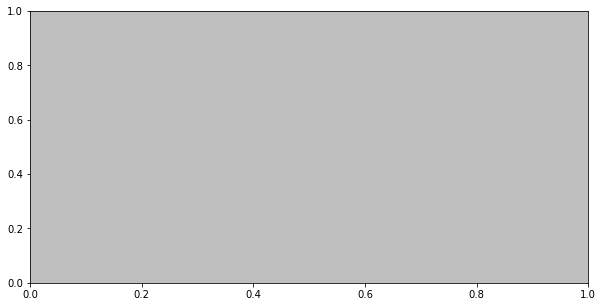

In [34]:
# From normal-surface integral of diagnosed horizontal heat fluxes
plt.figure(figsize=(10, 5))
plt.subplot(facecolor=(0.75, 0.75, 0.75))
pc = geoplot(
    ds,
    heat_flux_x.where(region.mask)*1e-9,   # convert unit: W to GW
    alpha=1.0, cmap="RdBu_r", vmin=-2e1, vmax=2e1
)
depth_cmap = plt.get_cmap("viridis_r").copy()
pc_dep = geoplot(ds, og.depth_ocean.where(~region.mask), cmap=depth_cmap)
plt.plot(lons, lats, "C3o", markersize=5, label="User-input boundary points (not necessarily on grid)")
plt.plot([],[],"k.",label="Boundary defined by grid cell corners")
plt.plot(reg.loop(region.lons), reg.loop(region.lats), "k-", linewidth=0.5, label="Consecutive velocity faces that approximate the boundary")
plt.plot(region.lons_uv, region.lats_uv, "k+", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column heat tendency [GW]")
plt.legend(loc = "upper left", fontsize=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()



### advective heat convergence

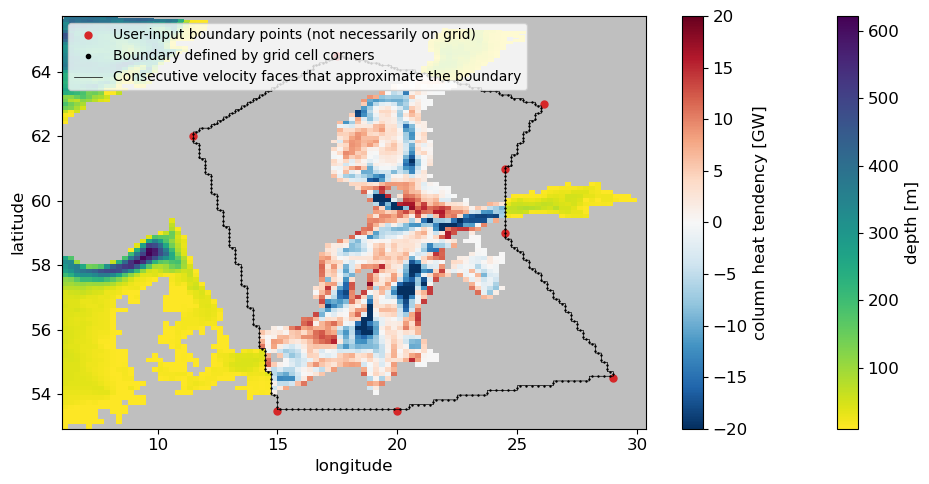

In [11]:
heat_flux_x_sum = (hf_y_319['T_ady']).sum('z_l')
heat_flux_x_sum  = heat_flux_x_sum .where(dheatdt_dynamics!=0.)

# From volume integral of horizontal advective tendencies
advective_heating = dheatdt_dynamics.where(region.mask).sum(['xh', 'yh']).values # LHS

# From normal-surface integral of diagnosed horizontal heat fluxes
convergent_heat_transport = sec.convergent_transport(
    grid,
    region.i,
    region.j,
    utr="T_adx",
    vtr="T_ady",
    layer="z_l",
    interface="z_i",
    outname="conv_heat_transport"
)['conv_heat_transport'].sum(["z_l", "sect"]).compute()

plt.figure(figsize=(10, 5))
plt.subplot(facecolor=(0.75, 0.75, 0.75))
pc = geoplot(
    ds,
    dheatdt_dynamics.where(region.mask)*1e-9,
    alpha=1.0, cmap="RdBu_r", vmin=-2e1, vmax=2e1
)
depth_cmap = plt.get_cmap("viridis_r").copy()
pc_dep = geoplot(ds, og.depth_ocean.where(~region.mask), cmap=depth_cmap)
plt.plot(lons, lats, "C3o", markersize=5, label="User-input boundary points (not necessarily on grid)")
plt.plot([],[],"k.",label="Boundary defined by grid cell corners")
plt.plot(reg.loop(region.lons), reg.loop(region.lats), "k-", linewidth=0.5, label="Consecutive velocity faces that approximate the boundary")
plt.plot(region.lons_uv, region.lats_uv, "k+", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column heat tendency [GW]")
plt.legend(loc = "upper left", fontsize=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()

if np.isclose(advective_heating.sum(), convergent_heat_transport.values, rtol=1.e-5):
    print(
    """
    We have verified that the convergent heat flux across the region's boundary
    is equal (within float32 precision) to the volume integral within the region.
    """
    )
else:
    print("We have no been able to reconcile boundary-normal fluxes with the volume integral.")

In [12]:
# From volume integral of horizontal advective tendencies
advective_heating = dheatdt_dynamics.where(region.mask).sum(['xh', 'yh']).values # LHS

# From normal-surface integral of diagnosed horizontal heat fluxes
convergent_heat_transport = sec.convergent_transport(
    grid,
    region.i,
    region.j,
    utr="T_adx",
    vtr="T_ady",
    layer="z_l",
    interface="z_i",
    outname="conv_heat_transport"
)['conv_heat_transport']

cumulative_convergent_heat_transport = (
    convergent_heat_transport
    .cumsum("sect").sel(z_l=ds.z_l[::-1])
    .cumsum('z_l').sel(z_l=ds.z_l[::-1])
).compute()

net_convergent_heat_transport = cumulative_convergent_heat_transport.isel(sect=-1, z_l=-1).values

print(f"Verify divergence theorem: {np.isclose(net_convergent_heat_transport, advective_heating, rtol=1.e-5, atol=0.)}")

Verify divergence theorem: True


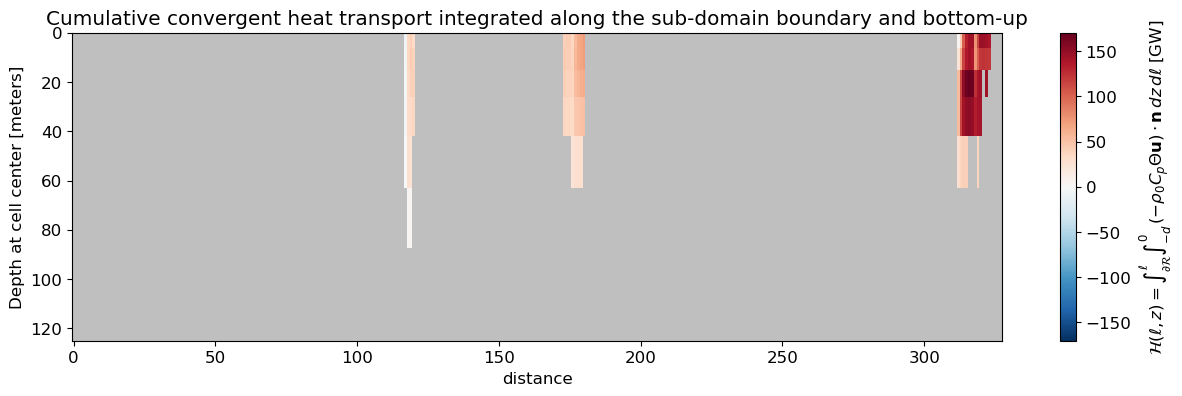

In [13]:
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad((0.75, 0.75, 0.75))
plt.figure(figsize=(15, 4))
da_plot = (
    (cumulative_convergent_heat_transport*1e-9)
    .where(convergent_heat_transport!=0.)
    .swap_dims({'sect':'distance'})
)
pc = da_plot.plot(x="distance", cmap=cmap)

plt.ylim(125, 0)
plt.title("Cumulative convergent heat transport integrated along the sub-domain boundary and bottom-up")
pc.colorbar.set_label(r"$\mathcal{H}(\ell, z) = \int_{\partial \mathcal{R}}^{\ell} \int_{-d}^{0} \, (- \rho_{0} C_{p} \Theta \mathbf{u})  \cdot \mathbf{n} \,dz\,d\ell$ [GW]")